In [1]:
import pandas as pd
import numpy as np
import wrds
import re
import requests
from fredapi import Fred
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv
import os

In [68]:
conn = wrds.Connection(wrds_username="nberzins")

Loading library list...
Done


In [69]:
conn.describe_table(library= "ff", table='fivefactors_daily')

Approximately 14836 rows in ff.fivefactors_daily.


,name,nullable,type,comment
0,date,True,DATE,Date
1,mktrf,True,"NUMERIC(8, 6)",Excess Return on the Market
2,smb,True,"NUMERIC(8, 6)",Small-Minus-Big Return
3,hml,True,"NUMERIC(8, 6)",High-Minus-Low Return
4,rmw,True,"NUMERIC(8, 6)",Robust Minus Weak Return
5,cma,True,"NUMERIC(8, 6)",Conservative Minus Aggressive Return
6,rf,True,"NUMERIC(7, 5)",Risk-Free Return Rate (One Month Treasury Bill...
7,umd,True,"NUMERIC(8, 6)",Momentum


In [70]:
sp500 = conn.raw_sql("""
                        SELECT a.*, b.date, b.ret
                        FROM crsp.dsp500list as a, crsp.dsf as b
                        WHERE a.permno=b.permno
                            AND b.date >= a.start and b.date <= a.ending
                            AND b.date >= '01/01/2000'
                        ORDER BY date; 
                        """, date_cols=['start', 'ending', 'date'])

In [71]:
dse = conn.raw_sql("""
                        SELECT comnam, namedt, nameendt, permno, siccd
                        FROM crsp.dsenames
                        """, date_cols=['namedt', 'nameendt'])

dse['Major Group'] = dse['siccd'] // 100

In [72]:
sic_groups = pd.read_csv("SIC_Major_Groups.csv")

dse = pd.merge(dse, sic_groups, how='left', on='Major Group')

In [73]:
fama_five = conn.raw_sql("""
                            SELECT *
                            FROM ff.fivefactors_daily as ff
                            WHERE ff.date >= '01/01/2000'
                            """)

fama_five["date"] = pd.to_datetime(fama_five["date"], format='%Y-%m-%d')

fama_five.tail(5)

,date,mktrf,smb,hml,rmw,cma,rf,umd
6284,2024-12-24,0.0111,-0.0012,-0.0005,-0.0013,-0.0037,0.00017,0.0067
6285,2024-12-26,0.0002,0.0109,-0.0019,-0.0044,0.0035,0.00017,0.0001
6286,2024-12-27,-0.0117,-0.0044,0.0056,0.0041,0.0003,0.00017,-0.0088
6287,2024-12-30,-0.0109,0.0024,0.0074,0.0055,0.0014,0.00017,0.0006
6288,2024-12-31,-0.0046,0.0031,0.0071,0.0033,0.0,0.00017,-0.0107


In [7]:
load_dotenv()

fred_api_key = os.getenv("FRED_API_KEY")

fred = Fred(api_key = fred_api_key)
fed_funds = fred.get_series('FEDFUNDS', observation_start='2000-01-01', observation_ends='2024-01-12')

In [75]:
ffer_df = fed_funds.to_frame(name="fed_funds_rate").reset_index()

ffer_df.describe()
ffer_df = ffer_df.rename(columns={"index": "date", "fed_funds_rate": "fed_funds_rate"})

ffer_df["date"] = pd.to_datetime(ffer_df["date"], format="%Y-%d-%m")
ffer_df["date"] = ffer_df["date"].dt.strftime('%Y-%m-%d')
ffer_df["date"] = pd.to_datetime(ffer_df["date"], format="%Y-%m-%d")

ffer_df = ffer_df[:-4]
ffer_df["fed_funds_rate"] = ffer_df["fed_funds_rate"] / 100
ffer_df

,date,fed_funds_rate
0,2000-01-01,0.0545
1,2000-02-01,0.0573
2,2000-03-01,0.0585
3,2000-04-01,0.0602
4,2000-05-01,0.0627
...,...,...
295,2024-08-01,0.0533
296,2024-09-01,0.0513
297,2024-10-01,0.0483
298,2024-11-01,0.0464


In [76]:
#Merging returns w/ company info

sp500_full = pd.merge(sp500, dse, how='left', on='permno')
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                             & (sp500_full.date<=sp500_full.nameendt)]

# Merging fama french factors and complete sp500 data

sp500_full = pd.merge(sp500_full, fama_five, how='left', on='date')

#Merging Federal Funds Rate Data 
#because only working with monthly values, have to break up the data into year and month then join on those two columns

sp500_full["month"] = sp500_full["date"].dt.month
sp500_full["year"] = sp500_full["date"].dt.year

ffer_df["month"] = ffer_df["date"].dt.month
ffer_df["year"] = ffer_df["date"].dt.year

#getting rid of unneccesary date column to avoid repeat column naames post-merge
ffer_df = ffer_df.drop(columns=["date"])

sp500_full = pd.merge(sp500_full, ffer_df, on=["year","month"], how="left")

# Removing now unnecessary month/year columns & repeat
sp500_full = sp500_full.drop(columns=["month", "year"])


In [77]:
# Date str --> Datetime conversion
sp500_full["date"] = pd.to_datetime(sp500_full["date"], format='%Y-%m-%d')

# ret, mktrf, smb, etc. --> log returns conversion
# Log-returns prove additive and will not impact future return-based factor calculations

cols_to_log = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf", "fed_funds_rate"]
sp500_full[cols_to_log] = np.log1p(sp500_full[cols_to_log])

In [78]:
sp500_full

,permno,start,ending,date,ret,comnam,namedt,nameendt,siccd,Major Group,Group Name,mktrf,smb,hml,rmw,cma,rf,umd,fed_funds_rate
0,25785,1957-03-01,2024-12-31,2000-01-03,-0.017741,FORD MOTOR CO DEL,1968-01-02,2000-08-02,3711,37,Transportation Equipment,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
1,13056,1989-10-05,2004-04-30,2000-01-03,-0.021391,AMERICAN GREETINGS CORP,1998-02-11,2002-01-01,2771,27,"Printing, Publishing, And Allied Industries",-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
2,60097,1986-10-23,2024-12-31,2000-01-03,-0.054639,MEDTRONIC INC,1999-01-04,2002-01-01,3845,38,"Measuring, Analyzing, And Controlling Instrume...",-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
3,60943,1999-10-18,2021-12-17,2000-01-03,-0.041672,LEGGETT & PLATT INC,1979-06-25,2002-01-01,2515,25,Furniture And Fixtures,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
4,51588,1998-01-28,2001-02-28,2000-01-03,-0.065355,SUMMIT BANCORP,1997-09-02,2001-02-28,6021,60,Depository Institutions,-0.007125,-0.0006,-0.0142,-0.015114,-0.006421,0.00021,-0.0008,0.053067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155298,69796,2005-07-05,2024-12-31,2024-12-31,0.006081,CONSTELLATION BRANDS INC,2014-04-10,2024-12-31,2084,20,Food And Kindred Products,-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155299,46703,2007-03-20,2024-12-31,2024-12-31,0.002247,HOST HOTELS & RESORTS INC,2020-11-02,2024-12-31,6798,67,Holding And Other Investment Offices,-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155300,79323,1995-07-13,2024-12-31,2024-12-31,0.001245,ALLSTATE CORP,2004-06-10,2024-12-31,6331,63,Insurance Carriers,-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825
3155301,90720,2023-12-18,2024-12-31,2024-12-31,-0.003074,BUILDERS FIRSTSOURCE INC,2021-07-19,2024-12-31,2421,24,"Lumber And Wood Products, Except Furniture",-0.004611,0.003095,0.007075,0.003295,0.0,0.00017,-0.0107,0.043825


**Store Data As CSV to avoid long pull request times from WRDS**

In [63]:
# sp500_full.to_csv("sp500_full.csv", index = False)

sp500_full = pd.read_csv("sp500_full.csv")

### Notable Industry Codes
- 50-59 = General Retail
- 60 = Depository Institutions (Banking)
- 63 = Insurance Carriers
- 73 = Business Services (Tech)

In [3]:
###### sp500_full[["Major Group", "Group Name"]].drop_duplicates().sort_values(by="Major Group")

# sp500_full[
#     (sp500_full["Major Group"].astype(int) >= 50) & 
#     (sp500_full["Major Group"].astype(int) <= 59)
# ]["comnam"].unique()

sp500_full[sp500_full["Major Group"] == 80]["comnam"].unique()

array(['COLUMBIA HCA HEALTHCARE CORP', 'MANOR CARE INC NEW',
       'HEALTHSOUTH CORP', 'TENET HEALTHCARE CORP', 'H C A HEALTHCARE CO',
       'H C A INC NEW', 'HEALTH MANAGEMENT ASSOCIATES INC',
       'QUEST DIAGNOSTICS INC', 'MEDCO HEALTH SOLUTIONS INC',
       'EXPRESS SCRIPTS INC', 'CAREMARK RX INC', 'APACHE CORP',
       'LABORATORY CORP AMERICA HLDGS',
       'CLEAR CHANNEL COMMUNICATIONS INC', 'WELLPOINT INC', 'DAVITA INC',
       'EXPRESS SCRIPTS HOLDING CO', 'DAVITA HEALTHCARE PARTNERS INC',
       'UNIVERSAL HEALTH SERVICES INC', 'H C A HOLDINGS INC',
       'ENVISION HEALTHCARE CORP', 'CARDINAL HEALTH INC',
       'AMERISOURCEBERGEN CORP', 'MCKESSON H B O C INC',
       'H C A HEALTHCARE INC', 'MOLINA HEALTHCARE INC',
       'LABCORP HOLDINGS INC'], dtype=object)

In [64]:
############## DAILY ################
# Calculating Volatility

sp500_full["volatility_21d"] = (
    sp500_full.groupby("comnam")["ret"]
    .rolling(window=21, min_periods=1)
    .std()
    .reset_index(level=0, drop = True)
    .fillna(0))

# Calculating 5 day Short-term reversal

sp500_full["5d_reversal"] = -(
    sp500_full.groupby("comnam")["ret"]
    .rolling(window=5, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

# Calculating 1 day lagged short-term reversal

sp500_full["1d_lag_reversal"] = -(
    sp500_full.groupby("comnam")["ret"].shift(1)
    .fillna(0)
)

In [85]:
#sp500_full = sp500_full[sp500_full["start"]]
# sp500_full[sp500_full["comnam"].isin(['COASTAL CORP'])].head(40)

(1330,)

In [108]:
factor_cols = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf", "umd", 
               "fed_funds_rate", "volatility_21d", "5d_reversal", "1d_lag_reversal"]

sp500_dly = {
    name: group[["date", "Major Group"] +factor_cols].reset_index(drop=True)
    for name, group in sp500_full.groupby("comnam")
}

sp500_dly["GENERAL ELECTRIC CO"]

,date,Major Group,ret,mktrf,smb,hml,rmw,cma,rf,umd,fed_funds_rate,volatility_21d,5d_reversal,1d_lag_reversal
0,2000-01-03,36,-0.031176,-0.007125,-0.000600,-0.014200,-0.015114,-0.006421,0.00021,-0.0008,0.053067,0.000000,0.031176,-0.000000
1,2000-01-04,36,-0.039521,-0.041447,0.003295,0.020391,0.004689,0.014396,0.00021,-0.0191,0.053067,0.005901,0.070697,0.031176
2,2000-01-05,36,-0.005216,-0.000900,0.003295,0.001599,0.004092,0.011039,0.00021,-0.0049,0.053067,0.017891,0.075912,0.039521
3,2000-01-06,36,0.015457,-0.007327,-0.000400,0.012521,0.006479,0.012027,0.00021,-0.0149,0.053067,0.025075,0.060455,0.005216
4,2000-01-07,36,0.037990,0.031596,-0.009444,-0.014302,-0.008839,-0.009646,0.00021,0.0056,0.053067,0.032180,0.022465,-0.015457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6284,2024-12-24,35,0.014508,0.011039,-0.001201,-0.000500,-0.001301,-0.003707,0.00017,0.0067,0.043825,0.020911,-0.033743,-0.003854
6285,2024-12-26,35,0.003842,0.000200,0.010841,-0.001902,-0.004410,0.003494,0.00017,0.0001,0.043825,0.020948,-0.073506,-0.014508
6286,2024-12-27,35,-0.010452,-0.011769,-0.004410,0.005584,0.004092,0.000300,0.00017,-0.0088,0.043825,0.020124,-0.033183,-0.003842
6287,2024-12-30,35,-0.011710,-0.010960,0.002397,0.007373,0.005485,0.001399,0.00017,0.0006,0.043825,0.019786,-0.000041,0.010452


In [7]:
factor_cols = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf"]
sp500_wkly = {}

for name, df in sp500_dly.items():

    #Converting to Weekly
    df = df.copy()
    df = df.drop(columns=["umd", "fed_funds_rate", "volatility_21d", "5d_reversal", "1d_lag_reversal"])
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    
    weekly_df = df[factor_cols].resample("W-MON", label="left", closed="left").sum().reset_index()

    # Adding 1-yr (lagged) momentum
    weekly_df["momentum_52w"] = (
        weekly_df["ret"]
        .shift(4)
        .rolling(window=52, min_periods=40)
        .sum()
    )

    # 4 (to 8) Week Volatility
    vol_window = 4
    weekly_df["volatility"] = weekly_df["ret"].rolling(window=vol_window, min_periods=3).std() 
    
    sp500_wkly[name] = weekly_df

sp500_wkly["GENERAL ELECTRIC CO"]

,date,ret,mktrf,smb,hml,rmw,cma,rf,momentum_52w,volatility
0,2000-01-03,-0.022465,-0.025204,-0.003856,0.006009,-0.008693,0.021395,0.00105,NaN,NaN
1,2000-01-10,-0.002068,0.020484,0.013664,-0.015142,-0.028502,0.000921,0.00105,NaN,NaN
2,2000-01-17,-0.046600,0.000377,0.058498,-0.026008,-0.049815,0.001161,0.00084,NaN,0.022292
3,2000-01-24,-0.072843,-0.058778,0.008962,0.016715,0.013913,0.016285,0.00105,NaN,0.030574
4,2000-01-31,0.054902,0.043595,-0.001359,-0.026716,-0.020247,-0.013999,0.00109,NaN,0.055937
...,...,...,...,...,...,...,...,...,...,...
1300,2024-12-02,-0.036789,0.010163,-0.013489,-0.030582,-0.008357,-0.013135,0.00085,0.706034,0.032570
1301,2024-12-09,-0.056047,-0.009292,-0.009654,-0.001631,0.024498,-0.012535,0.00085,0.622827,0.036817
1302,2024-12-16,0.014116,-0.022998,-0.019514,-0.014670,-0.009697,0.006406,0.00085,0.646063,0.033599
1303,2024-12-23,0.011751,0.005551,-0.003306,0.001281,0.001177,0.006665,0.00068,0.630755,0.035170


In [121]:
factor_cols = ["ret", "mktrf", "smb", "hml", "rmw", "cma", "rf"]
sp500_monthly = {}

for name, df in sp500_dly.items():

    #Converting to Monthly
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"]) # double checking date time conversion
    df.set_index("date", inplace=True)

    monthly_df = df[factor_cols].resample("MS", label="left", closed="left").sum().reset_index()

    #Don't lose the major group value in conversion
    major_group_value = df["Major Group"].dropna().iloc[-1]
    monthly_df["Major Group"] = major_group_value
    #Make sure cols are in right position
    cols = monthly_df.columns.tolist()
    cols.remove("Major Group")
    cols.insert(1, "Major Group")
    monthly_df = monthly_df[cols]


    #Adding 1-yr (lagged) momentum
    monthly_df["momentum_12m"] = (
        monthly_df["ret"].shift(1).rolling(window=12, min_periods=10).sum()
    )

    # 3 (to 6) Month Volatility 
    vol_window = 3
    monthly_df["volatility"] = monthly_df["ret"].rolling(window=vol_window, min_periods=2).std()

    monthly_df = monthly_df.dropna(axis=0) #getting rid of rows without calculated factor values due
                                           #to necessary rolling window

    #If the company has at least 1 years worth of data, proceed to analysis
    if monthly_df.shape[0] >= 2:

        sp500_monthly[name] = {
           "data": monthly_df, 
            "models": {} 
        }

        X = monthly_df.iloc[:, 3:] #skip first two columns (date and returns)
        Y = monthly_df["ret"]
    
        lin_model = LinearRegression().fit(X,Y)
        lasso_model = Lasso().fit(X,Y)
        
        # pcr_model = Pipeline([
        #     ("pca", PCA(n_components=len(X.columns))),
        #     ("reg", LinearRegression())
        # ]).fit(X,Y)
    
        sp500_monthly[name]["models"] = {
            "OLS": lin_model,
            "LASSO": lasso_model#,
            # "PCR": pcr_model
        }

    #If the comapny doesnt have at least 1 years worht of data, do nothing
    #Will not be added to sp500_monthly
    else:
        pass

In [117]:
# sp500_monthly["GENERAL ELECTRIC CO"]["models"]["OLS"].intercept_
sp500_monthly["GENERAL ELECTRIC CO"]["data"]


,date,Major Group,ret,mktrf,smb,hml,rmw,cma,rf,momentum_12m,volatility
10,2000-11-01,35,-0.100684,-0.113602,-0.005943,0.126947,0.143560,0.089683,0.005039,0.068797,0.043103
11,2000-12-01,35,-0.030022,0.011862,0.030382,0.067429,0.014604,0.050604,0.004999,-0.031886,0.036273
12,2001-01-01,35,-0.041690,0.033040,0.050929,-0.054106,-0.057914,-0.072310,0.005459,-0.061909,0.037880
13,2001-02-01,35,0.011247,-0.106025,0.029075,0.128849,0.096562,0.100753,0.003800,0.043180,0.027814
14,2001-03-01,35,-0.101578,-0.075398,0.022983,0.063095,0.034081,0.035591,0.004180,0.063826,0.056448
...,...,...,...,...,...,...,...,...,...,...,...
295,2024-08-01,35,0.025636,0.015823,-0.035579,-0.011704,0.006412,0.009254,0.004839,0.631857,0.054320
296,2024-09-01,35,0.078426,0.017199,-0.009971,-0.026891,0.000638,-0.001640,0.004000,0.655569,0.028358
297,2024-10-01,35,-0.093308,-0.009547,-0.008098,0.008430,-0.015303,0.009860,0.003910,0.768038,0.087965
298,2024-11-01,35,0.058669,0.062820,0.044137,0.000962,-0.025044,-0.020240,0.004000,0.692251,0.093968


In [140]:
#Collecting the OLS Coefficients for each company
ols_coefs = []

for name in sp500_monthly:
    comp_coefs = pd.Series(sp500_monthly[name]["models"]["OLS"].coef_)
    major_group = sp500_monthly[name]["data"]["Major Group"].unique()[0]
    major_group = pd.Series([major_group], index=["Major Group"])
    comp_coefs = pd.concat([major_group, comp_coefs])
    ols_coefs.append(comp_coefs)

ols_coefs = pd.DataFrame(ols_coefs)
ols_coefs.columns = ['Major Group','mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf',
                     'momentum_12m', 'volatility']

ols_coefs

,Major Group,mktrf,smb,hml,rmw,cma,rf,momentum_12m,volatility
0,38.0,0.908569,0.347189,-0.012462,0.691763,0.444734,1.792805,-0.008768,-0.129500
1,36.0,1.610027,0.726654,-1.290403,-0.416329,1.824896,-4.920629,0.013388,0.291327
2,73.0,1.296422,1.159210,-0.725234,1.746604,1.386740,476.598224,-0.034580,-0.190805
3,49.0,1.160448,0.582385,0.400920,-0.809483,-0.221654,-1.531460,-0.030998,-0.246719
4,49.0,-0.211665,0.278892,0.177444,-0.017985,1.133604,86.131194,-0.081251,0.501527
...,...,...,...,...,...,...,...,...,...
1195,38.0,1.138791,-0.130384,0.052309,-0.411972,0.428529,-2.339552,-0.090100,-0.238232
1196,38.0,0.777618,0.374825,0.302961,0.417510,-0.077637,-2.998510,-0.025127,-0.314549
1197,60.0,0.783524,-0.334494,2.303260,-0.959124,-0.428684,-0.593154,0.023723,0.078794
1198,60.0,0.708672,1.250149,1.759841,-0.541522,-1.369753,-0.695389,0.008041,-0.027310


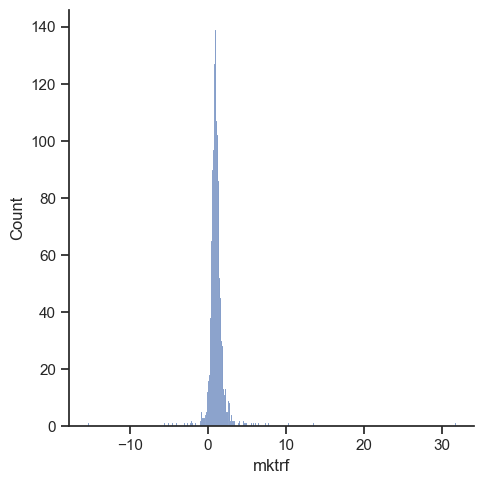

In [125]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.displot(ols_coefs, x="mktrf")

In [1]:
# panel_df = []

# for name, df in sp500_monthly.items():
#     df = df.copy()
#     df["comnam"] = name
#     panel_df.append(df)
    
# panel_df = pd.concat(panel_df, ignore_index=True)

In [94]:
# from sklearn.linear_model import LinearRegression, LassoCV
# from sklearn.decomposition import PCA
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# # OLS
# ols = LinearRegression().fit(X,y)

# # PCR
# pcr = make_pipeline(StandardScaler(), PCA(n_components=min(5, X.shape[1])), LinearRegression())
# pcr.fit(X,y)

# # LASSO w/ cross-val
# lasso = make_pipeline(StandardScaler(), LassoCV(cv=5)).fit(X,y)

In [ ]:
#Need to Build Different Retun-Based Factors from Returns 

#e.g. Momentum, Volatility from past 30 days, market portfolio, banking/construction (responsive to IR), IR itself,
# others can be extracxted from French Fama ---- Shoot for 10 - 15 predictors for first iteration

# *Maybe find sentiment indices*

In [ ]:
#For next week -----------------------------

# Convert to weekly + Monthly data, too much noise in daily 
# Many large positions flip before market close to avoid sitting overnight 

#Focus on predictors and run standard models in ord

In [ ]:
# Next iteration would be to just include a ton of different predictors, 